# Land Cover Classification using Deep Learning Techniques and EuroSAT

## Mounting google drive for dataset access and saving models

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!ls gdrive/MyDrive

'185533 (1).pdf'
'185533 (2).pdf'
'185533 (3).pdf'
'185533 (4).pdf'
'185533 Ada.pdf'
'185533 CD Assignment (1).pdf'
'185533 CD Assignment.pdf'
'185533 CD.pdf'
'185533 CE.pdf'
'185533 Dbms mid sem.pdf'
'185533 MAS Test.pdf'
'185533 NN.pdf'
 185533.pdf
'185533 - Resume'
 185533.zip
'Ada 185533.pdf'
'Anand Kumar (185533).pdf'
'Anand'\''s Resume (185533).pdf'
'Behaviour Assignment.gdoc'
 Classroom
'Colab Notebooks'
'Computer Networks Lab Final Assignment .gdoc'
'DBMS LAB 1 (185533).docx'
'DBMS LAB 2 (185533).pdf'
'DBMS LAB 3 (185533).pdf'
'DBMS LAB 4 (185533).pdf'
'DBMS LAB 5 - 6 (185533).pdf'
 Demo_Outlook_Account_Gen.mp4
'dwt-zsuu-ywk - Sep 21, 2021.gjam'
'Edited - 185533csd320(1).pdf'
'Edited - 185533csd320.pdf'
 Image_Dataset.zip
'Information Security Lab (185533).gdoc'
'Information Security Lab (185533).pdf'
'Information Security Lab Assignment 2 (185533).pdf'
'Information Security Lab Assignment 3 (185533).gdoc'
'Information Security Lab Assignment 3 (185533).pdf'
'Information Securi

In [3]:
!unzip gdrive/MyDrive/Image_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Image_Dataset/SeaLake/SeaLake_2827.jpg  
  inflating: Image_Dataset/SeaLake/SeaLake_1418.jpg  
  inflating: Image_Dataset/SeaLake/SeaLake_1816.jpg  
  inflating: Image_Dataset/SeaLake/SeaLake_671.jpg  
  inflating: Image_Dataset/SeaLake/SeaLake_1360.jpg  
  inflating: Image_Dataset/SeaLake/SeaLake_50.jpg  
  inflating: Image_Dataset/SeaLake/SeaLake_2154.jpg  
  inflating: Image_Dataset/SeaLake/SeaLake_1820.jpg  
  inflating: Image_Dataset/SeaLake/SeaLake_2650.jpg  
  inflating: Image_Dataset/SeaLake/SeaLake_2596.jpg  
  inflating: Image_Dataset/SeaLake/SeaLake_1931.jpg  
  inflating: Image_Dataset/SeaLake/SeaLake_607.jpg  
  inflating: Image_Dataset/SeaLake/SeaLake_2114.jpg  
  inflating: Image_Dataset/SeaLake/SeaLake_1812.jpg  
  inflating: Image_Dataset/SeaLake/SeaLake_1653.jpg  
  inflating: Image_Dataset/SeaLake/SeaLake_1995.jpg  
  inflating: Image_Dataset/SeaLake/SeaLake_2329.jpg  
  inflating: Image_Dataset/SeaLake/

## Libraries

In [4]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm
import seaborn as sns


from sklearn.metrics import confusion_matrix
from sklearn import model_selection

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

## Config

In [5]:
ROOT_PATH = os.getcwd()
BASE_PATH = os.path.join(ROOT_PATH, 'Image_Dataset')
DATA_PATH = os.path.join(ROOT_PATH, 'Dataset')
FULL_DATA_DF = os.path.join(ROOT_PATH, 'FULL_DATA.csv')

if not os.path.isdir(DATA_PATH):
    os.mkdir(DATA_PATH)

IDX_CLASS_LABELS = {
    0: 'AnnualCrop',
    1: 'Forest', 
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}
CLASSES = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture','PermanentCrop','Residential','River', 'SeaLake']
CLASS_IDX_LABELS = dict()
for key, val in IDX_CLASS_LABELS.items():
    CLASS_IDX_LABELS[val] = key

NUM_CLASSES = len(IDX_CLASS_LABELS.items())
torch.manual_seed(10)
VALID_SIZE = 0.1


In [6]:
ROOT_PATH
print(torch.cuda.is_available())

True


In [7]:
CLASS_IDX_LABELS

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

## Utils

In [8]:
## Give idx of each class name
def encode_label(label):
    idx = CLASS_IDX_LABELS[label] 
    return idx

## Take in idx and return the class name
def decode_target(target, text_labels=True):
    result = []
    if text_labels:
        return IDX_CLASS_LABELS[target]
    else:
        return target

## Show batches of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [9]:
## Example for decoding and encoding
print(encode_label('Forest'), decode_target(2))
print(decode_target(2, text_labels=True))

1 HerbaceousVegetation
HerbaceousVegetation


## Pre-Processing data folders to train and test
Run this code cells only if you don't have the required dataframe

In [10]:
from os import walk
i = 0
for (dirpath, dirname, filename) in walk(BASE_PATH):
    print("Directory Path: ", dirpath)
    print("Directory Name: ", dirname)
    print("Filename : ", filename)
    print("----------------------"*10)
    i += 1
    if i > 1:
        break

Directory Path:  /content/Image_Dataset
Directory Name:  ['Pasture', 'PermanentCrop', 'AnnualCrop', 'Highway', 'SeaLake', 'River', 'HerbaceousVegetation', 'Industrial', 'Residential', 'Forest']
Filename :  []
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Directory Path:  /content/Image_Dataset/Pasture
Directory Name:  []
Filename :  ['Pasture_1944.jpg', 'Pasture_85.jpg', 'Pasture_1449.jpg', 'Pasture_414.jpg', 'Pasture_1004.jpg', 'Pasture_1104.jpg', 'Pasture_1582.jpg', 'Pasture_456.jpg', 'Pasture_647.jpg', 'Pasture_479.jpg', 'Pasture_1950.jpg', 'Pasture_1982.jpg', 'Pasture_1340.jpg', 'Pasture_1033.jpg', 'Pasture_286.jpg', 'Pasture_1099.jpg', 'Pasture_677.jpg', 'Pasture_409.jpg', 'Pasture_1762.jpg', 'Pasture_1519.jpg', 'Pasture_1276.jpg', 'Pasture_1502.jpg', 'Pasture_1174.jpg', 'Pasture_133.jpg', 'Pasture_753.jpg', 

In [11]:
from os import walk

i = 0
DATA_DF = pd.DataFrame(columns = ['image_id', 'label'], dtype=object) 

for (dirpath, dirname, filename) in walk(BASE_PATH):
    for each_file in filename:
        DATA_DF.loc[i] = [each_file, dirpath.split('/')[-1]]
        i += 1
        # break
DATA_DF.to_csv(FULL_DATA_DF, index=False)
DATA_DF.head()


,image_id,label
0,Pasture_1944.jpg,Pasture
1,Pasture_85.jpg,Pasture
2,Pasture_1449.jpg,Pasture
3,Pasture_414.jpg,Pasture
4,Pasture_1004.jpg,Pasture


## Processing data folders to train and test


In [12]:
DATA_DF = pd.read_csv(FULL_DATA_DF)
DATA_DF = DATA_DF.sample(frac = 1, random_state=48) 
TRAIN_DF = DATA_DF[:-int(len(DATA_DF)*VALID_SIZE)]
VALID_DF = DATA_DF[-int(len(DATA_DF)*VALID_SIZE) :]

In [13]:
TRAIN_DF.reset_index(inplace = True) 
TRAIN_DF.head()

,index,image_id,label
0,19127,Industrial_1121.jpg,Industrial
1,3197,PermanentCrop_1053.jpg,PermanentCrop
2,24557,Forest_711.jpg,Forest
3,17042,HerbaceousVegetation_1039.jpg,HerbaceousVegetation
4,3697,PermanentCrop_651.jpg,PermanentCrop


In [14]:
VALID_DF.reset_index(inplace = True) 
VALID_DF.head()

,index,image_id,label
0,21985,Residential_327.jpg,Residential
1,25621,Forest_1253.jpg,Forest
2,21573,Residential_534.jpg,Residential
3,25070,Forest_2225.jpg,Forest
4,13947,River_1225.jpg,River


In [15]:
TRAIN_DF.size, VALID_DF.size

(72900, 8100)

## Creating Dataset and Dataloaders

Now we will Create custom dataset by extending pytorch Dataset class. We also add provision for adding transformers for data augmentation.

In [16]:
class EuroSAT(Dataset):
    def __init__(self, train_df, train_dir, transform=None):
        self.train_dir = train_dir
        self.train_df = train_df
        self.transform = transform
        
    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self, idx):
        row = self.train_df.loc[idx]
        img_id, label = row['image_id'], row['label']
        img = Image.open(os.path.join(self.train_dir, img_id.split('.')[0].split('_')[0], img_id))
        if self.transform:
            img = self.transform(img)
        return img, encode_label(label)

### Transformations and Datasets

In [17]:
## Dataset and transformations
data_transform = transforms.Compose([
                                transforms.Resize(size=(224, 224)),
#                                 transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
train_ds = EuroSAT(TRAIN_DF, BASE_PATH, data_transform)
valid_ds = EuroSAT(VALID_DF, BASE_PATH, data_transform)
print(len(train_ds), len(valid_ds))

24300 2700


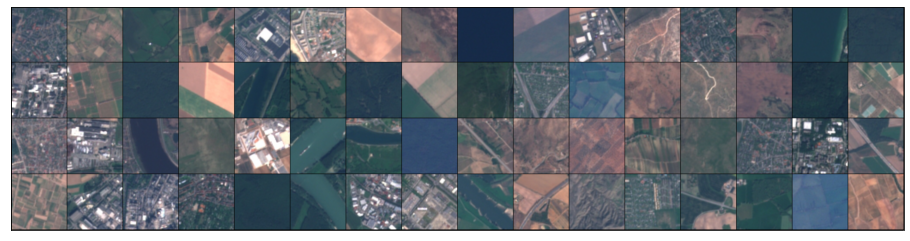

In [18]:
## Data loaders and showing batch of data
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True)
show_batch(train_dl)

## Model

In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

class MulticlassClassifierBase(nn.Module):
    
    def training_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return accu ,loss
    def validation_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return {"val_loss": loss.detach(), "val_acc": accu}
    
    def validation_epoch_ends(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(), "val_acc":epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_accu: {:.4f}, learning_rate: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_accu'], result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [20]:
class LULC_Model(MulticlassClassifierBase):
    def __init__(self):
        super().__init__()
        self.network = models.wide_resnet50_2(pretrained=True)
        n_inputs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
                              nn.Linear(n_inputs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, NUM_CLASSES),
                              nn.LogSoftmax(dim=1)
                                )
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad=False
        for param in self.network.fc.parameters():
            param.require_grad=True
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad=True

In [21]:
model = LULC_Model()

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

In [22]:
## Running through the data loader => Model => Output
def try_batch(dl):
    for images, labels in dl:  
        print(images.shape)
        out = model(images)
        print(out.shape)
        print(out[0])
        break
try_batch(train_dl)

torch.Size([64, 3, 224, 224])
torch.Size([64, 10])
tensor([-2.4710, -2.3706, -2.5106, -2.0749, -2.3350, -2.1098, -1.9959, -2.4485,
        -2.5083, -2.3699], grad_fn=<SelectBackward0>)


## Training and Evaluating

In [23]:
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_ends(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs, max_lr,  model, train_loader, valid_loader, weight_decay=0,\
                grad_clip=None,opt_func=torch.optim.SGD, max_epochs_stop=3):
  
    history = []
    valid_loss_min = np.Inf
    valid_acc_max = 0
    model_file_name = 'lulc.pth'
    model_file_name2 = 'lulc_max_acc.pth'
    epochs_no_improve =  0
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.00001)
                         
    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_accu = []
        lrs = []
        for batch in tqdm(train_loader):
            
            accu, loss = model.training_step(batch)
            train_loss.append(loss)
            train_accu.append(accu)
            loss.backward()
            ## Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            
            
            
        result = evaluate(model, valid_loader)
        scheduler.step(result['val_loss'])
        ########### Early Stopping ##############                                         
        valid_loss = result['val_loss']
        valid_acc = result['val_acc']
        if valid_acc > valid_acc_max:
            torch.save(model.state_dict(), model_file_name2)
            valid_acc_max = valid_acc
        if valid_loss<valid_loss_min:
            torch.save(model.state_dict(), model_file_name)
            valid_loss_min = valid_loss                                  
            epochs_no_improve = 0          
        else:
            epochs_no_improve += 1
            if epochs_no_improve > max_epochs_stop:
                result["train_loss"] = torch.stack(train_loss).mean().item()
                result["train_accu"] = torch.stack(train_accu).mean().item()
                result["lrs"] = lrs
                model.epoch_end(epoch, result)
                history.append(result)
                print("Early Stopping............................")
                return history                                
                                                 
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["train_accu"] = torch.stack(train_accu).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    print("VAL LOSS MIN {}".format(valid_loss_min))
    print("VAL ACC MAX {}".format(valid_acc_max))
    return history

## Initializing Device also Loading Data and Model to device¶


In [25]:
def get_device():
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [26]:
device = get_device()
## Loading data to devide
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
## Loading model to device
model = to_device(LULC_Model(), device)
## lets try passing a batch to model again
try_batch(train_dl)

True
torch.Size([64, 3, 224, 224])
torch.Size([64, 10])
tensor([-2.3598, -2.2277, -2.1588, -2.2402, -2.4023, -2.2145, -2.3377, -2.3850,
        -2.5076, -2.2439], device='cuda:0', grad_fn=<SelectBackward0>)


In [27]:
torch.cuda.empty_cache()

## Training

In [28]:
## Hyper Parameters
max_epochs_stop = 10
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 10
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model, valid_dl)

{'val_acc': 0.10307655483484268, 'val_loss': 2.306993007659912}

In [29]:
## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.9252, learning_rate: 0.0001, train_loss: 0.2836, val_loss: 0.0843, val_acc: 0.9717


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.9643, learning_rate: 0.0001, train_loss: 0.1151, val_loss: 0.0802, val_acc: 0.9702


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.9744, learning_rate: 0.0001, train_loss: 0.0859, val_loss: 0.0887, val_acc: 0.9675


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.9755, learning_rate: 0.0001, train_loss: 0.0816, val_loss: 0.1096, val_acc: 0.9648


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.9771, learning_rate: 0.0001, train_loss: 0.0784, val_loss: 0.0928, val_acc: 0.9677


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.9773, learning_rate: 0.0000, train_loss: 0.0732, val_loss: 0.0796, val_acc: 0.9727


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.9781, learning_rate: 0.0000, train_loss: 0.0713, val_loss: 0.0767, val_acc: 0.9746


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.9769, learning_rate: 0.0000, train_loss: 0.0747, val_loss: 0.0710, val_acc: 0.9775


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.9782, learning_rate: 0.0000, train_loss: 0.0730, val_loss: 0.0770, val_acc: 0.9742


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.9789, learning_rate: 0.0000, train_loss: 0.0702, val_loss: 0.0829, val_acc: 0.9727
VAL LOSS MIN 0.07099087536334991
VAL ACC MAX 0.9774709343910217


## Reports

### Training Reports

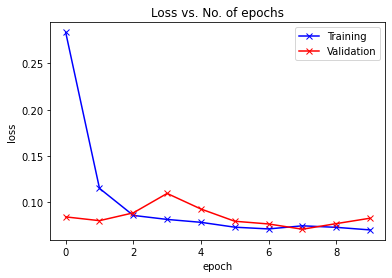

In [30]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

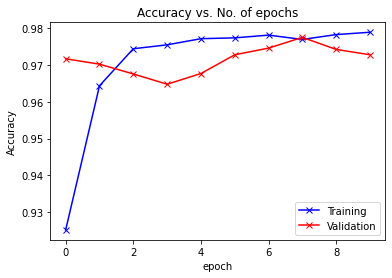

In [31]:
def plot_accuracy(history):
        
    train_accu = [x.get('train_accu') for x in history]
    val_accu = [x['val_acc'] for x in history]
    plt.plot(train_accu, '-bx')
    plt.plot(val_accu, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
plot_accuracy(history)

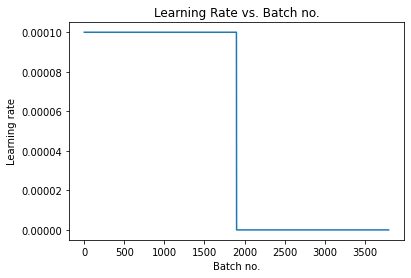

In [32]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_lrs(history)

### Prediction Reports

In [33]:
def show_sample(img, target=None):
    if target:
        print("Label" ,decode_target(int(target), text_labels=True))
    plt.imshow(img.permute(1, 2, 0))

### Predict Single Images
def predict_single(image):
    show_sample(image)
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    _, prediction = torch.max(preds.cpu().detach(), dim=1)
    return decode_target(int(prediction), text_labels=True)


'HerbaceousVegetation'

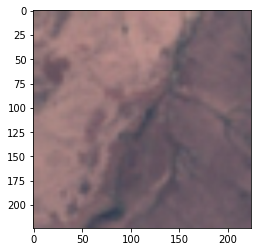

In [34]:
predict_single(valid_ds[40][0])

'Highway'

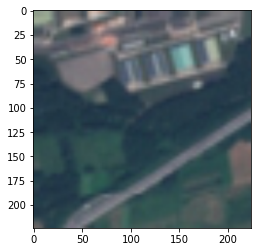

In [35]:
predict_single(valid_ds[30][0])

'River'

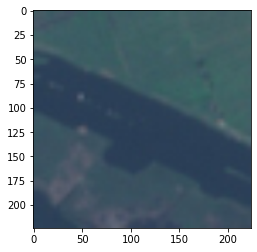

In [36]:
predict_single(valid_ds[90][0])

## Evaluation on whole dataset

In [37]:
batch_size =1
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_pred, labels = [], []
    for xb, label in tqdm(dl):
        probs = model(xb)
        _, pred = torch.max(probs.cpu().detach(), dim=1)
        batch_pred.append(pred.cpu().detach())     
        labels.append(label)   
    return [x for x in batch_pred], \
            [x for x in labels]

In [38]:

## Accuracy Evaluation
def final_accuracy(predictions, labels):
  predictions = to_device(predictions, device)
  labels = to_device(labels, device)
  ## Total Accuracy
  total = 0
  for i in range(len(predictions)):
    if predictions[i] == labels[i]:
      total += 1
  acc = total/len(predictions)
  print(acc)

In [39]:
full_ds = EuroSAT(DATA_DF, BASE_PATH, data_transform)
full_dl = DataLoader(full_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
device = get_device()
## Loading data to devide
full_dl = DeviceDataLoader(full_dl, device)


True


In [40]:
predictions, labels = predict_dl(full_dl, model)
final_accuracy(predictions, labels)
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]
cm = confusion_matrix(preds, labs)
cm

  0%|          | 0/27000 [00:00<?, ?it/s]

0.9877037037037038


array([[2972,    0,   14,    0,    0,    8,   27,    0,    5,    0],
       [   0, 2969,    0,    0,    0,    0,    0,    0,    1,    0],
       [   0,    2, 2943,    0,    0,    3,   13,    0,   17,    0],
       [   3,    0,    1, 2499,   46,    0,    6,    6,   48,    0],
       [   0,    0,    1,    0, 2447,    0,    0,    2,    1,    0],
       [   1,    2,   22,    0,    0, 1988,    8,    0,    8,    0],
       [   9,    0,    6,    0,    0,    0, 2441,    0,    0,    0],
       [   0,    0,    0,    0,    6,    0,    4, 2992,    0,    0],
       [   7,    0,    0,    1,    1,    0,    0,    0, 2417,    0],
       [   8,   27,   13,    0,    0,    1,    1,    0,    3, 3000]])

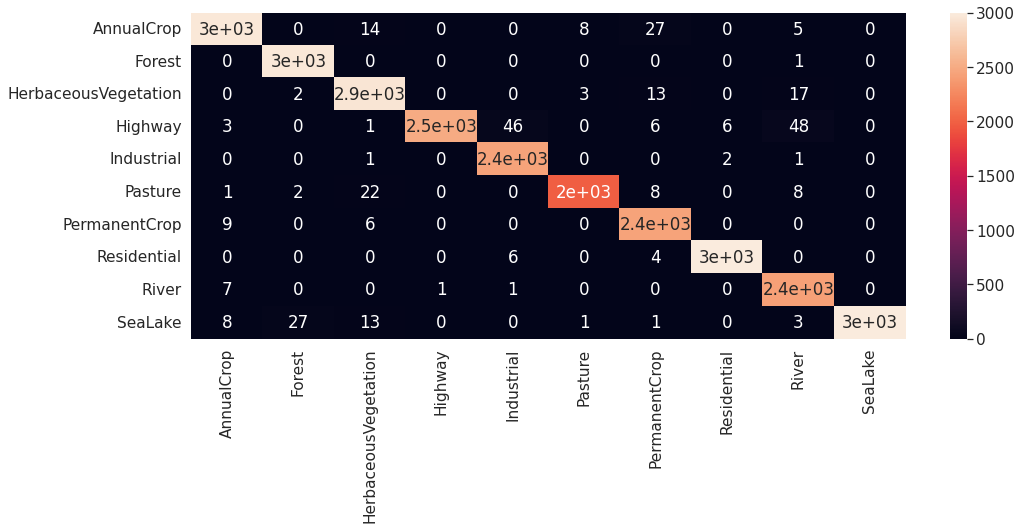

In [41]:
## Plotting Confusion matrix
df_cm = pd.DataFrame(cm, CLASSES, CLASSES)
sns.set(font_scale=1.4) # for label size
plt.figure(figsize = (16,6))
sns.heatmap(df_cm, annot=True)

In [42]:
## Evaluation with best validation accuracy model
model = LULC_Model()
model.load_state_dict(torch.load("/content/lulc_max_acc.pth"))
model.eval()
model = to_device(model, device)
predictions, labels = predict_dl(full_dl, model)
final_accuracy(predictions, labels)
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]
cm = confusion_matrix(preds, labs)
cm

  0%|          | 0/27000 [00:00<?, ?it/s]

0.9901111111111112


array([[2963,    0,   10,    0,    0,    7,   23,    0,    4,    0],
       [   1, 2993,    1,    0,    0,    0,    1,    0,    2,    0],
       [   0,    2, 2949,    0,    0,    3,   16,    0,   17,    0],
       [   3,    0,    1, 2499,   25,    0,    5,    5,   32,    0],
       [   0,    0,    1,    0, 2470,    0,    0,    2,    1,    0],
       [   1,    0,   25,    0,    0, 1990,    8,    0,   10,    0],
       [   9,    0,    5,    0,    0,    0, 2445,    0,    0,    0],
       [   0,    0,    0,    0,    4,    0,    1, 2993,    0,    0],
       [  16,    0,    0,    1,    1,    0,    0,    0, 2431,    0],
       [   7,    5,    8,    0,    0,    0,    1,    0,    3, 3000]])

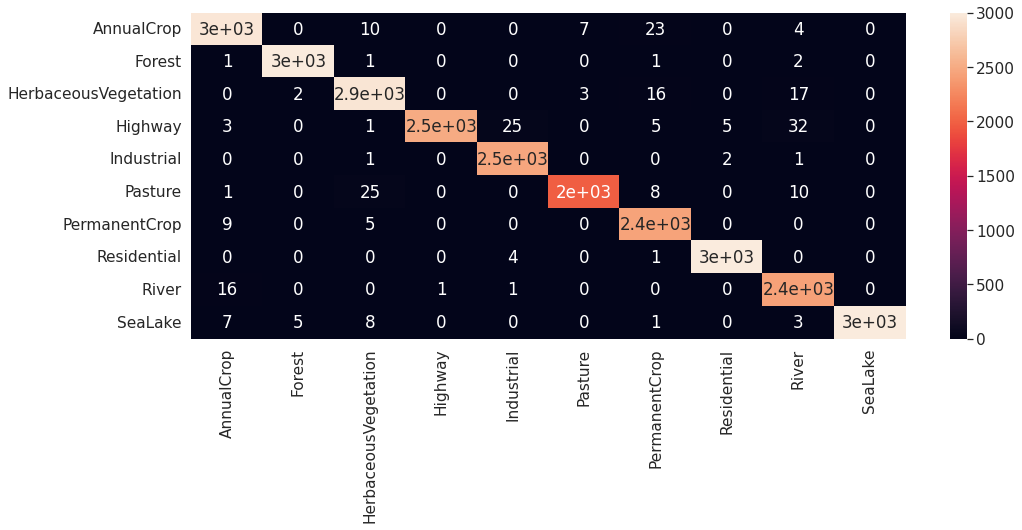

In [43]:
## Plotting Confusion matrix
df_cm = pd.DataFrame(cm, CLASSES, CLASSES)
sns.set(font_scale=1.4) # for label size
plt.figure(figsize = (16,6))
sns.heatmap(df_cm, annot=True)